# MPRA regression of background samples with K-fold cross validation

### Environment 
The next chunk contains the commands necessary to install the environment required to run this jupyter notebook
Skip this chunk if the installation was previously done

In [42]:
%%bash
conda create --name tf_MPRA python=3.9.7
conda activate tf_MPRA
pip install tensorflow[and-cuda]
conda install -c anaconda ipykernel
conda install -c anaconda pandas
conda install -c anaconda numpy
conda install -c anaconda scikit-learn 
conda install -c conda-forge matplotlib

# After installation if you are using VSCODE to run the notebook you have to close it and re-open

Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda





## Package Plan ##

  environment location: /home/felix/anaconda3/envs/tensorflow_2_gpu

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-2.1.1               |   py39h1128e8f_0        13.5 MB  anaconda
    python-tzdata-2023.3       |     pyhd3eb1b0_0         149 KB  anaconda
    ------------------------------------------------------------
                                           Total:        13.6 MB

The following NEW packages will be INSTALLED:

  python-tzdata      anaconda/noarch::python-tzdata-2023.3-pyhd3eb1b0_0 None

The following packages will be UPDATED:

  pandas                               1.5.2-py39h417a72b_0 --> 2.1.1-py39h1128e8f_0 None


Proceed ([y]/n)? 

python-tzdata-2023.3 | 149 KB    | ########## | 100% 
pandas-2.1.1         | 13.5 MB   | ########## | 100% 
Preparing transaction: ...working... done
Verifying transact



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda





## Package Plan ##

  environment location: /home/felix/anaconda3/envs/tf_MPRA

  added / updated specs:
    - python=3.9.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    openssl-1.1.1w             |       h7f8727e_0         3.7 MB
    pip-23.3                   |   py39h06a4308_0         2.6 MB
    ------------------------------------------------------------
                                           Total:         6.5 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main None
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu None
  ca-certificates    pkgs/main/linux-64::ca-certificates-2023.08.22-h06a4308_0 None
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.38-h1181459_1 None
  libffi             pkgs/main/linux-64::libffi-3.3-he

### Library imports


In [7]:
import os 
import getopt
import sys

import random
import re

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Masking, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf
from tensorflow import keras



### Input ingestion

Here we define the methods to read and ingest data and we initialize the random seed.

Since we are processing the background the vocabulary is comprised of lower case nucleotides.

The upper cases (where the motif is), will be encoded as a zero-like vector

In [8]:
np.random.seed(1337) # for reproducibility

# Lower case vocabulary
vocab = ["a", "c", "g", "t"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets=1)

# These are the defaults of the data reader method 
# (each column in the ingested csv must be initialized with the right data type, otherwise the data ingestion fails )
defs = [0.] * 1 + [tf.constant([], dtype="string")] + [tf.constant([], dtype="string")]


def data_reader(file, batch_size=100, n_parse_threads=4):
    """Method for reading the data in an optimized way, can be used inside model.fit()
    
    Args:
        file (_type_): path to csv file
        batch_size (int, optional): _description_. Defaults to 100.
        n_parse_threads (int, optional): _description_. Defaults to 4.

    Returns:
        dataset.batch: batch dataset object 
    """
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    """Preprocessing method of a dataset object, one-hot-encodes the data

    Args:
        record (_type_): _description_

    Returns:
        X (2D np.array): one-hot-encoded input sequence
        Y (1D np.array): MPRA measurements

    """
    # Extract fields from passed batch
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])     # Extract sequences from 1st field
    chars_indices = table.lookup(chars)     # one-hot-encoding
    
    # Create a mask for out-of-vocabulary characters
    oov_mask = tf.equal(chars_indices, len(vocab))
    
    # Explicitly cast the value to int64
    chars_indices = tf.where(oov_mask, tf.constant(len(vocab), dtype=tf.int64), chars_indices)
    
    X = tf.one_hot(chars_indices, depth=len(vocab))
    Y = fields[0]
    return X, Y


### Randomization of motif sequences and data augmentation

This chunk defines a function that takes a dataframe with sequences and replaces upper case characters with random sequences N times

In [6]:
def randomize_motifs_and_augment(df, num_augmentations=100):
    """This methods takes a dataframe containing a 'seq' column, randomizes the upper case characters and augments this sequences n times

    Args:
        df (pd.DataFrame): dataframe containing a 'seq' column
        num_augmentations (int, optional): Number of random sequences to obtaining for each input sequence. Defaults to 100.

    Returns:
        df (pd.DataFrame): df with an additional 'rnd_seq' column containing randomized upper case sequences, each sequence has N augmentation additional rows.
    """
    augmented_sequences = []

    for sequence in df['seq']:
        for _ in range(num_augmentations):
            random_sequence = ''.join(random.choice("ACGT") if char.isupper() else char for char in sequence)
            augmented_sequences.append(random_sequence)

    augmented_df = pd.DataFrame({'rnd_seq': augmented_sequences})
    df = df.loc[df.index.repeat(num_augmentations)].reset_index(drop=True)
    df = pd.concat([df, augmented_df], axis=1)
    return df

# Example data frame with DNA sequences

# test dataframe
data = {'seq': ["aaaACGTAGGCTA", "tttTTACGGTACACGT", "cccCGTACATACAGT"],
        'id' : ["1a", "2a", "3a"]}
df = pd.DataFrame(data)

# Call the randomize_motifs_and_augment function
result_df = randomize_motifs_and_augment(df, num_augmentations=3)

# Display the resulting data frame
result_df

,seq,id,rnd_seq
0,aaaACGTAGGCTA,1a,NaN
1,aaaACGTAGGCTA,1a,NaN
2,aaaACGTAGGCTA,1a,NaN
3,tttTTACGGTACACGT,2a,NaN
4,tttTTACGGTACACGT,2a,NaN
5,tttTTACGGTACACGT,2a,NaN
6,cccCGTACATACAGT,3a,NaN
7,cccCGTACATACAGT,3a,NaN
8,cccCGTACATACAGT,3a,NaN
0,NaN,NaN,aaaCTAGTCGACG


### k-fold cross validation split
Here we take the initial csv file and we split it in 3 partitions k times

It is possible to randomize the sequences and augment, since the masking of the model motifs was a better choice
for understanding the background this strategy is here commented out and not used


In [13]:
# CROSS VALIDATION (10 fold)
from sklearn.model_selection import train_test_split, KFold

whole_data = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/no_upper_LibA_wide_pivot_state3.csv"
out_data = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/"
# Split the data in two partitions
whole_data = pd.read_csv(whole_data)
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 2008)

o=1
# For each fold we split again to get the third partition
for i in kf.split(whole_data):
    
    # Extract data from fold
    train = whole_data.iloc[i[0]]
    test =  whole_data.iloc[i[1]]
    
    # Split into train, validation and test
    valid, validation = train_test_split(train, test_size=0.111, random_state=42)
    
    # Randomize motifs
    #train = randomize_motifs_and_augment(train, num_augmentations=100)
    #train["rnd_seq"] = train['rnd_seq'].str.lower() 
    #test = randomize_motifs_and_augment(test, num_augmentations=100)
    #test["rnd_seq"] = test['rnd_seq'].str.lower() 
    #validation = randomize_motifs_and_augment(validation, num_augmentations=100)
    #validation["rnd_seq"] = validation['rnd_seq'].str.lower() 
    
    train[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1
    

### Masking motifs

Since we do not want to backpropagate through the masked values we apply a mask on them

The mask is applied on values one-hot-encoded as a zero-like vector

Here we test the behaviour of the mask method to make sure it not masking 0 contained in every vector

In [14]:
# Define the masking layer with mask_value=0
masking_layer = tf.keras.layers.Masking(mask_value=0.0)

# Example input tensor with shape (batch_size, sequence_length, vocab_size)
input_tensor = tf.constant([
    [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0]],
    [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]
], dtype=tf.float32)

# Apply the masking layer to the input tensor
masked_tensor = masking_layer(input_tensor)

print(masked_tensor)
masking_layer.compute_mask(input_tensor)

tf.Tensor(
[[[0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]], shape=(2, 3, 5), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[False,  True,  True],
       [ True,  True, False]])>

### Deep Learning model

Here we run the model which is based on this paper : 

https://doi.org/10.1101/2023.03.05.531189

I have added a Normalization layer parametrized with two parameters. Here we define the custom layer, the method to compute pearson correlation and a plotting function

In [15]:
# Here we initialize the df where each fold test prediction will be appended to
# the list containing the correlations of each fold is also initialized
df_test_10folds  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
corr_list = []

# We define a custom normalization layer to then compile on the model
class CustomNormalization(Layer):
    """Custom normalization layer that normalizes the output of the neural network"""
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

# We define the method to compute the pearson correlation between prediction and ground truth
def pearson_correlation(x, y):
    """Computes Pearson Correlation between x and y
    Args:
        x (np.array): vector of predictions values
        y (np.array): vector of ground truth values

    Returns:
        (float): pearson correlation
    """
    n = len(x)
    
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation

import matplotlib.pyplot as plt
%matplotlib inline
# Define plotting function of loss
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()

#### Model training
Here we iterate through the folds and train the model

In [19]:
# We iterate through each of the train folds to train, test and validate the model
for i in range(1,11):
    
    #Define inputs
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
    
    # Read test data to then predict
    df_test = pd.read_csv(input_path_test)

    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape

    # Define and compile model
    inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
    inputs = Masking()(inputs)
    layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
    layer = Dropout(0.5)(layer)
    layer = BatchNormalization()(layer)
    layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
    layer = Dropout(0.3)(layer)
    layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
    layer = BatchNormalization()(layer)
    layer = Dropout(0.5)(layer)
    layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
    layer = Dropout(0.5)(layer)
    layer = Flatten()(layer)
    layer = Dense(300, activation='sigmoid')(layer)  # 300
    layer = Dropout(0.5)(layer)
    layer = Dense(200, activation='sigmoid')(layer)  # 300
    predictions = Dense(1, activation='linear')(layer)
    norm_predictions = CustomNormalization()(predictions)  # Assuming "predictions" is your existing output

    model = Model(inputs=inputs, outputs=norm_predictions)
    model.summary()

    # compile model
    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse", "mae", "mape"],
                )

    # Run model
    history=model.fit(data_reader(input_path_train, batch_size=100),
                            epochs=20,
                            validation_data=data_reader(input_path_valid,batch_size=500),
                            callbacks=None,
                            verbose=1)
    
    #After training we save the model weights to then run the contribution scores
    model_path = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/test_background.h5"
    model.save_weights(model_path, save_format='h5') 
    
    # We predict the test data
    predicted = model.predict(data_reader(input_path_test, batch_size=500))

    # We reed the data in the same order to compute the correlation score
    test_data = data_reader(input_path_test,batch_size=500)
    test_tensor = np.empty(shape=[0,1])
    for batch in test_data:
        test_tensor = np.append(test_tensor, batch[1])

    # We fill the dataframe with predictions and fold annotation
    df_test["prediction"] = predicted
    df_test["fold"] = str(i)
    df_test["partition"] = "test"
    
    # Append fold to previous folds
    df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)    
    # Append correlation coefficient and append to previous
    corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
    corr_list.append(corr_coefficient)

# Save the results for all folds
df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_LibA_wide_pivot_state3_test_predicted_cv10fold.csv", index=False)

df_test_10folds


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_100 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_80 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_81 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                        

2023-11-10 12:55:14.943120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 2s 24ms/step - loss: 0.0597 - mse: 0.0597 - mae: 0.1784 - mape: 9509.8574 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1615 - val_mape: 173.5569
Epoch 3/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1711 - mape: 10959.9570 - val_loss: 0.0528 - val_mse: 0.0528 - val_mae: 0.1764 - val_mape: 333.8909
Epoch 4/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0532 - mse: 0.0532 - mae: 0.1679 - mape: 8220.0303 - val_loss: 0.0860 - val_mse: 0.0860 - val_mae: 0.2518 - val_mape: 675.1546
Epoch 5/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1630 - mape: 4676.3574 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2528 - val_mape: 679.3126
Epoch 6/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0486 - mse: 0.0486 - mae: 0.1618 - mape: 9238.5537 - val_loss: 0.0987 - val_mse: 0.0987 - val_mae: 0.2752 - val_mape: 759.3158


2023-11-10 12:55:52.073541: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_105 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_84 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_85 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                        

2023-11-10 12:55:58.187942: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 12:55:58.188023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 2s 24ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1798 - mape: 20431.4160 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.1752 - val_mape: 133.8401
Epoch 3/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1709 - mape: 13575.4512 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1923 - val_mape: 696.6546
Epoch 4/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0518 - mse: 0.0518 - mae: 0.1659 - mape: 18095.3652 - val_loss: 0.0659 - val_mse: 0.0659 - val_mae: 0.1988 - val_mape: 765.5031
Epoch 5/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1634 - mape: 5387.7866 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.2097 - val_mape: 868.4425
Epoch 6/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1618 - mape: 11735.6426 - val_loss: 0.0715 - val_mse: 0.0715 - val_mae: 0.2150 - val_mape: 917.88

2023-11-10 12:56:34.924906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_110 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_88 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_89 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                        

2023-11-10 12:56:41.188506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 12:56:41.188582: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 2s 23ms/step - loss: 0.0627 - mse: 0.0627 - mae: 0.1832 - mape: 15678.7295 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.1946 - val_mape: 450.7902
Epoch 3/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1709 - mape: 15567.7588 - val_loss: 0.0678 - val_mse: 0.0678 - val_mae: 0.2009 - val_mape: 486.3112
Epoch 4/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0547 - mse: 0.0547 - mae: 0.1704 - mape: 16778.3066 - val_loss: 0.0757 - val_mse: 0.0757 - val_mae: 0.2195 - val_mape: 579.3629
Epoch 5/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0526 - mse: 0.0526 - mae: 0.1671 - mape: 8791.9727 - val_loss: 0.0909 - val_mse: 0.0909 - val_mae: 0.2495 - val_mape: 709.2432
Epoch 6/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0496 - mse: 0.0496 - mae: 0.1618 - mape: 8656.1826 - val_loss: 0.1085 - val_mse: 0.1085 - val_mae: 0.2803 - val_mape: 827.504

2023-11-10 12:57:18.005958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_115 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_92 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_93 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                        

2023-11-10 12:58:01.167020: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_120 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_96 (Ba  (None, 256, 250)          1000      
 tchNormalization)                                               
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_97 (Ba  (None, 249, 250)          1000      
 tchNormalization)                                        

2023-11-10 12:58:06.879775: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 12:58:06.879882: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 5s 28ms/step - loss: 0.1461 - mse: 0.1461 - mae: 0.2719 - mape: 56502.5664 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1975 - val_mape: 546.2224
Epoch 2/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0635 - mse: 0.0635 - mae: 0.1839 - mape: 44262.1055 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1843 - val_mape: 464.7532
Epoch 3/20
77/77 [==============================] - 2s 25ms/step - loss: 0.0585 - mse: 0.0585 - mae: 0.1755 - mape: 7211.3638 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.1929 - val_mape: 519.9112
Epoch 4/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0543 - mse: 0.0543 - mae: 0.1692 - mape: 7098.5054 - val_loss: 0.0647 - val_mse: 0.0647 - val_mae: 0.1994 - val_mape: 556.8600
Epoch 5/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0521 - mse: 0.0521 - mae: 0.1667 - mape: 4008.6555 - val_loss: 0.0793 - val_mse: 0.0793 - val_mae: 0.2322 - val_mape: 714.5884

2023-11-10 12:58:46.517498: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_125 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_100 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_101 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-11-10 12:58:52.204444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 12:58:52.204532: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 5s 27ms/step - loss: 0.1030 - mse: 0.1030 - mae: 0.2384 - mape: 115384.9609 - val_loss: 0.0575 - val_mse: 0.0575 - val_mae: 0.1726 - val_mape: 327.6359
Epoch 2/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0613 - mse: 0.0613 - mae: 0.1793 - mape: 24254.2793 - val_loss: 0.0582 - val_mse: 0.0582 - val_mae: 0.1795 - val_mape: 468.0911
Epoch 3/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1729 - mape: 9591.9873 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1882 - val_mape: 567.7629
Epoch 4/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0544 - mse: 0.0544 - mae: 0.1705 - mape: 3513.0959 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1875 - val_mape: 560.8610
Epoch 5/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1665 - mape: 7941.7793 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.2044 - val_mape: 708.099

2023-11-10 13:00:18.042705: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_135 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_108 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_109 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-11-10 13:00:23.666764: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 13:00:23.666864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 5s 25ms/step - loss: 0.1096 - mse: 0.1096 - mae: 0.2448 - mape: 24728.7832 - val_loss: 0.0600 - val_mse: 0.0600 - val_mae: 0.1793 - val_mape: 454.8930
Epoch 2/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0634 - mse: 0.0634 - mae: 0.1823 - mape: 17873.0742 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1787 - val_mape: 445.6925
Epoch 3/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0569 - mse: 0.0569 - mae: 0.1723 - mape: 12633.8525 - val_loss: 0.0627 - val_mse: 0.0627 - val_mae: 0.1879 - val_mape: 564.1794
Epoch 4/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0542 - mse: 0.0542 - mae: 0.1695 - mape: 3998.9282 - val_loss: 0.0622 - val_mse: 0.0622 - val_mae: 0.1865 - val_mape: 549.5057
Epoch 5/20
77/77 [==============================] - 2s 24ms/step - loss: 0.0521 - mse: 0.0521 - mae: 0.1669 - mape: 2201.4797 - val_loss: 0.0836 - val_mse: 0.0836 - val_mae: 0.2354 - val_mape: 920.936

2023-11-10 13:00:58.982183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_140 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_112 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_113 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-11-10 13:01:04.703712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 13:01:04.703787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 2s 23ms/step - loss: 0.0595 - mse: 0.0595 - mae: 0.1773 - mape: 31674.5410 - val_loss: 0.0483 - val_mse: 0.0483 - val_mae: 0.1617 - val_mape: 322.6002
Epoch 3/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0559 - mse: 0.0559 - mae: 0.1718 - mape: 18921.9355 - val_loss: 0.0486 - val_mse: 0.0486 - val_mae: 0.1607 - val_mape: 275.6092
Epoch 4/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0530 - mse: 0.0530 - mae: 0.1677 - mape: 30039.4512 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2347 - val_mape: 1134.0214
Epoch 5/20
77/77 [==============================] - 2s 23ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1636 - mape: 12088.1367 - val_loss: 0.0728 - val_mse: 0.0728 - val_mae: 0.2284 - val_mape: 1087.3951
Epoch 6/20
77/77 [==============================] - 6s 54ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1624 - mape: 8105.0400 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.2114 - val_mape: 956.

2023-11-10 13:01:45.418587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 262, 4)]          0         
                                                                 
 conv1 (Conv1D)              (None, 256, 250)          7250      
                                                                 
 dropout_145 (Dropout)       (None, 256, 250)          0         
                                                                 
 batch_normalization_116 (B  (None, 256, 250)          1000      
 atchNormalization)                                              
                                                                 
 conv2 (Conv1D)              (None, 249, 250)          500250    
                                                                 
 batch_normalization_117 (B  (None, 249, 250)          1000      
 atchNormalization)                                       

2023-11-10 13:01:50.777771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12619460392470034905
2023-11-10 13:01:50.777862: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 422699371556086469


77/77 [==============================] - 5s 25ms/step - loss: 0.0837 - mse: 0.0837 - mae: 0.2150 - mape: 7854.4434 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1782 - val_mape: 133832.3438
Epoch 2/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0607 - mse: 0.0607 - mae: 0.1798 - mape: 11520.8125 - val_loss: 0.0658 - val_mse: 0.0658 - val_mae: 0.1743 - val_mape: 53489.1016
Epoch 3/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0567 - mse: 0.0567 - mae: 0.1729 - mape: 19120.9727 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1745 - val_mape: 105358.1797
Epoch 4/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0529 - mse: 0.0529 - mae: 0.1677 - mape: 16290.6797 - val_loss: 0.0897 - val_mse: 0.0897 - val_mae: 0.2433 - val_mape: 306244.3750
Epoch 5/20
77/77 [==============================] - 2s 22ms/step - loss: 0.0502 - mse: 0.0502 - mae: 0.1636 - mape: 6612.6816 - val_loss: 0.0979 - val_mse: 0.0979 - val_mae: 0.2594 - val_ma

,State_3E,seq,prediction,CRS,fold,partition
0,-0.005304,aggaccggatcaactaaacaactcaaacaagggctaatataaccca...,-0.019658,LibA.Seq7829,1,test
1,0.236881,aggaccggatcaactaaacactagtcatacttaaaaattgcaagga...,-0.019426,LibA.Seq271,1,test
2,-0.086491,aggaccggatcaactaaacaggttctgacgtatgctcctctatgga...,-0.019860,LibA.Seq4548,1,test
3,-0.087684,aggaccggatcaactaaacccgagcctgcctagccctagcttctct...,-0.019592,LibA.Seq4582,1,test
4,0.371111,aggaccggatcaactaaacggagcagagttagtgtcaggtcaaaaa...,-0.019807,LibA.Seq2863,1,test
...,...,...,...,...,...,...
25471,-0.076574,aggaccggatcaacttttggtcggttgacggtcgccttgattattc...,0.089834,LibA.Seq4154,10,test
25472,0.369648,aggaccggatcaactttttcagtgaaagatcaccgcgggatctcac...,0.256202,LibA.Seq8531,10,test
25473,-0.098525,aggaccggatcaacttttttagtaaaactcttaaacagtgattaca...,0.125644,LibA.Seq6744,10,test
25474,0.164442,aggaccggatcaacttttttatctggttatcattctagtctagtgc...,0.023373,LibA.Seq1298,10,test


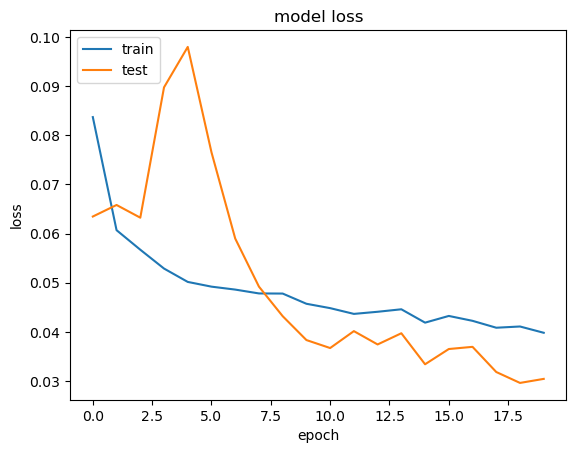

<Figure size 640x480 with 0 Axes>

In [20]:
create_plots(history)